In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



In [ ]:
# create sastrawi stopword
stopword_factory = StopWordRemoverFactory()
stopword = stopword_factory.create_stop_word_remover()

# create sastrawi stemmer
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

In [ ]:
# functions for cleaning, removing stopwords
def preprocess_text(text):
    text = str(text)

    # change text to lowercase
    text = text.lower()

    # change link with http/https patterns
    text = re.sub(r'http\S+', '', text)

    # remove hashtag and username
    text = re.sub(r'(@\w+|#\w+)', '', text)

    # remove character other than a-z and A-Z
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # replace new line '\n' with space
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\t', ' ', text)

    # remove stopword with sastrawi library
    text = stopword.remove(text)

    # do stemming with sastrawi library
    text = stemmer.stem(text)

    # removing more than one space
    text = re.sub(r'\s{2,}', ' ', text)

    return text

In [ ]:
# text preprocessing
df['text'] = df['text'].swifter.apply(preprocess_text)

In [2]:
df = pd.read_json("https://raw.githubusercontent.com/tantowjy/news-classification/main/dataset/talas-preprocessing/dataset-talas-preprocess-830.json")

In [3]:
# separating features and labels
X = df['text'].values
y = df['liberalism_conservative'].values

In [4]:
# Split the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
vocab_size = 10000
char_vocab_size = 50
embedding_dim = 128
char_embedding_dim = 50
max_length = 100
max_char_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

In [6]:
# Create tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

# Converting text to numeric squences
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Padding the squences
padded_train_sequences = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Create tokenizer for characters
char_tokenizer = Tokenizer(char_level=True)
char_tokenizer.fit_on_texts(X_train)

# Converting text to numeric sequences of characters
train_char_sequences = char_tokenizer.texts_to_sequences(X_train)
test_char_sequences = char_tokenizer.texts_to_sequences(X_test)

# Padding the sequences
padded_train_char_sequences = pad_sequences(train_char_sequences, maxlen=max_char_length, padding=padding_type, truncating=trunc_type)
padded_test_char_sequences = pad_sequences(test_char_sequences, maxlen=max_char_length, padding=padding_type, truncating=trunc_type)

# Ensure input shapes are tensors
padded_train_sequences = tf.constant(padded_train_sequences)
padded_test_sequences = tf.constant(padded_test_sequences)
padded_train_char_sequences = tf.constant(padded_train_char_sequences)
padded_test_char_sequences = tf.constant(padded_test_char_sequences)

In [7]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.layers import GlobalAveragePooling1D, BatchNormalization, MaxPooling1D
from tensorflow.keras.layers import Flatten, GlobalMaxPool1D, SpatialDropout1D, Conv1D
from tensorflow.keras.layers import Input, Concatenate, Attention, Reshape, Layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2, l1_l2

In [8]:
model_B = Sequential()
model_B.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
model_B.add(Bidirectional(LSTM(64, return_sequences=True)))
model_B.add(Dropout(0.3))
model_B.add(GlobalMaxPool1D())
model_B.add(Dense(16, activation='relu', kernel_regularizer=l2(l2=0.001)))
model_B.add(BatchNormalization())
model_B.add(Dense(6, activation='relu'))
model_B.add(Dense(1, activation='sigmoid'))

In [9]:
# compile model
model_B.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# model training
history = model_B.fit(padded_train_sequences, y_train,
                      epochs=300,
                      validation_data=(padded_test_sequences, y_test),
                      batch_size=32,
                      callbacks=[early_stopping])

Epoch 1/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6054 - loss: 0.6750 - val_accuracy: 0.7485 - val_loss: 0.7062
Epoch 2/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9325 - loss: 0.3693 - val_accuracy: 0.8204 - val_loss: 0.6679
Epoch 3/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9659 - loss: 0.2195 - val_accuracy: 0.8563 - val_loss: 0.6279
Epoch 4/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9927 - loss: 0.1185 - val_accuracy: 0.8503 - val_loss: 0.5816
Epoch 5/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9968 - loss: 0.0719 - val_accuracy: 0.8144 - val_loss: 0.5635
Epoch 6/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9968 - loss: 0.0558 - val_accuracy: 0.8263 - val_loss: 0.5241
Epoch 7/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9985 - loss: 0.0438 - val_accuracy: 0.7545 - val_loss: 0.5374
Epoch 8/300
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9961 - loss: 0.0457 - val_accuracy: 0.

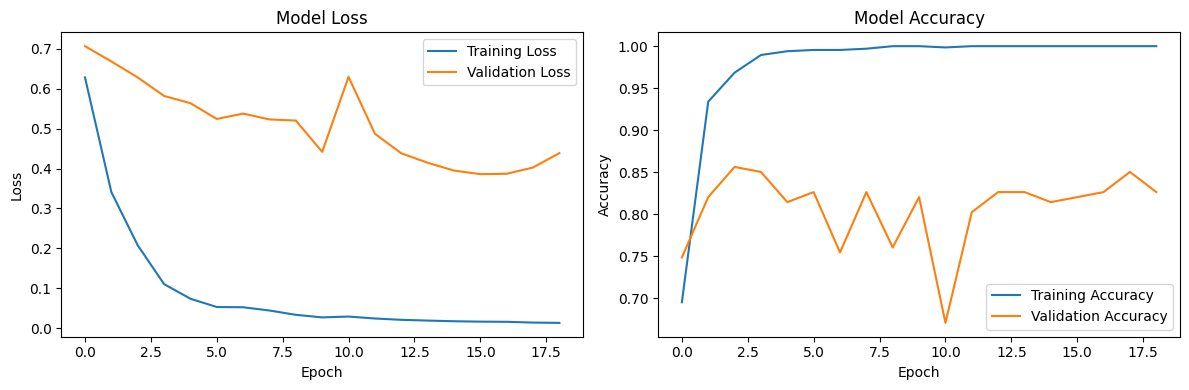

In [10]:
# training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

### Evaluate and save model

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8249 - loss: 0.3628 
Test Accuracy: 82.04%
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


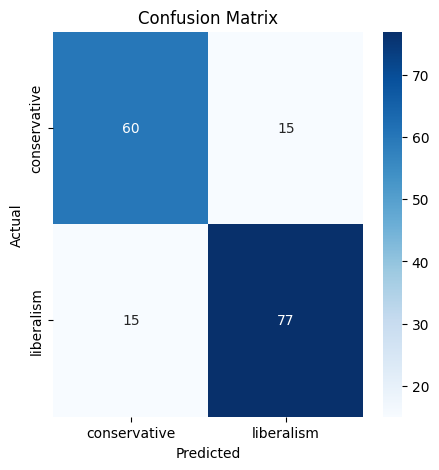

In [11]:
import pickle

# Evaluate the model
loss, accuracy = model_B.evaluate(padded_test_sequences, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred_prob = model_B.predict(padded_test_sequences)
y_pred = (y_pred_prob > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['conservative','liberalism'], yticklabels=['conservative','liberalism'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Save the model with HDF5 format
model_B.save('liberalism_conservative_B.h5')

# Save the model with pickle format
with open('tokenizer_liberalism_conservative_B.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

### Convert to TFLite

In [12]:
# Convert the model with Select TF ops
converter = tf.lite.TFLiteConverter.from_keras_model(model_B)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

# Save the model
with open('liberalism_conservative_B.tflite', 'wb') as f:
    f.write(tflite_model)

print('Model has been saved as TensorFlow Lite format.')

INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmph7sbvzut\assets


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmph7sbvzut\assets


Saved artifact at 'C:\Users\USER\AppData\Local\Temp\tmph7sbvzut'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2694303824976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2694303825744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2694307283600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2694307285136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2694307285520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2694307285904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2694307286864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2694307287056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2694307288016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2694307288976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2694307289360:

In [14]:
with open('tokenizer_liberalism_conservative_B.pkl', 'rb') as f:
    tokenizer_loaded = pickle.load(f)

assert tokenizer.word_index == tokenizer_loaded.word_index, "Tokenizers do not match!"

In [15]:
# Reload the saved model
from keras.models import load_model

model_loaded = load_model('liberalism_conservative_B.h5')

# Evaluate the reloaded model on the same test data
loss, accuracy = model_loaded.evaluate(padded_test_sequences, y_test)
print(f'Test Accuracy after loading: {accuracy * 100:.2f}%')

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8249 - loss: 0.3628  
Test Accuracy after loading: 82.04%


In [17]:
# Ensure the same max_len is used
assert max_length == 100, "Padding length does not match training setup!"

# Ensure the padded sequences are of correct shape
print("Shape of padded test sequences:", padded_test_sequences.shape)

Shape of padded test sequences: (167, 100)


In [19]:
# Inspect prediction probabilities
y_pred_prob = model_loaded.predict(padded_test_sequences)
print("Sample prediction probabilities:", y_pred_prob[:10].flatten())

# Check the range of probabilities
print("Min probability:", y_pred_prob.min())
print("Max probability:", y_pred_prob.max())
print("Mean probability:", y_pred_prob.mean())

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Sample prediction probabilities: [0.69458014 0.91610587 0.13154595 0.78703433 0.59705764 0.95996094
 0.93270576 0.1629668  0.78141034 0.88106287]
Min probability: 0.030967044
Max probability: 0.97014576
Mean probability: 0.5350562


In [22]:
# Check class distribution
import numpy as np
print("Class distribution in y_train:", np.bincount(y_train))
print("Class distribution in y_test:", np.bincount(y_test))

Class distribution in y_train: [308 358]
Class distribution in y_test: [75 92]


In [23]:
from sklearn.metrics import confusion_matrix

# Generate predictions
y_pred = (y_pred_prob > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[60 15]
 [15 77]]


Accuracy for each class:
Liberal: 95.33%
Konservatif: 96.34%
Total correct predictions:
{'Liberal': 429, 'Konservatif': 369}


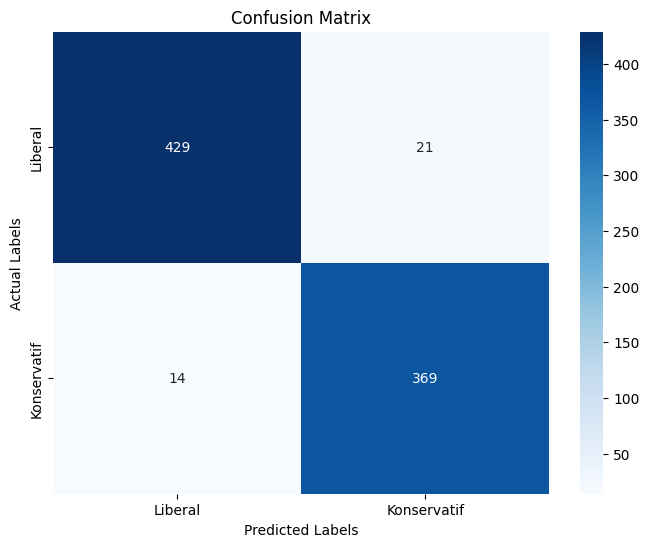

Confusion Matrix:
[[429  21]
 [ 14 369]]

Conservative Texts:
Text: Wakil Presiden (Wapres) RI Ma'ruf Amin berharap Bendungan Cipanas yang terletak di Desa Cibuluh, Kecamatan Ujungjaya, Kabupaten Sumedang, Jawa Barat dapat menjadi destinasi wisata baru.“Bendungan ini juga berpotensi untuk dijadikan daerah wisata baru," kata Ma'ruf seusai meresmikan Bendungan Cipanas, Selasa (9/7/2024).Wapres mengatakan, Bendungan Cipanas memiliki peran strategis dalam mendukung kehidupan manusia dan perekonomian.Ia menyebutkan, manfaat dari Bendungan ini, tidak hanya berfungsi sebagai sumber air baku, tetapi juga mendukung ketahanan pangan dan energi."Bendungan ini akan menyediakan berbagai fungsi pemenuhan kebutuhan masyarakat mulai dari sumber irigasi pertanian, sumber air baku, pengendali banjir, dan pembangkit listrik," kata Ma'ruf.Baca juga: Bendungan Cipanas Diresmikan, Bisa buat Pembangkit Listrik Tenaga Surya Terapung"Selain itu, bendungan ini akan membantu meningkatkan intensitas tanam dan pro

In [43]:
import pandas as pd
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
import pickle
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

y_actual = df['liberalism_conservative'].values
y_predicted = []

with open('tokenizer_liberalism_conservative_B.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

interpreter = tf.lite.Interpreter(model_path='liberalism_conservative_B.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

max_len = 100 
sequences = tokenizer.texts_to_sequences(df['content'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
padded_sequences = padded_sequences.astype('float32')
padded_sequences = tf.constant(padded_sequences)
correct_predictions = {'Liberal': 0, 'Konservatif': 0}
total_predictions = {'Liberal': 0, 'Konservatif': 0}

for idx, content in enumerate(padded_sequences):
    interpreter.set_tensor(input_details[0]['index'], [content])
    interpreter.invoke()

    predictions = interpreter.get_tensor(output_details[0]['index'])

    # Get the predicted label
    predicted_label = 1 if predictions[0] > 0.76 else 0
    y_predicted.append(predicted_label)
    actual_label = df['liberalism_conservative'].iloc[idx]

    # Update counts
    label_name = 'Liberal' if actual_label == 1 else 'Konservatif'
    if predicted_label == actual_label:
        correct_predictions[label_name] += 1
    total_predictions[label_name] += 1

# Calculate accuracy for each class
accuracy = {label: correct_predictions[label] / total_predictions[label] if total_predictions[label] > 0 else 0
            for label in correct_predictions}

# Display the results
print("Accuracy for each class:")
for label, acc in accuracy.items():
    print(f"{label}: {acc:.2%}")

print("Total correct predictions:")
print(correct_predictions)

y_predicted = np.array(y_predicted)
conf_matrix = confusion_matrix(y_actual, y_predicted, labels=[1, 0])  # Liberal = 1, Konservatif = 0
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Liberal', 'Konservatif'], yticklabels=['Liberal', 'Konservatif'])
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

# Optionally print the confusion matrix as text
print("Confusion Matrix:")
print(conf_matrix)

# Print texts predicted as conservative
print("\nConservative Texts:")
for idx, predicted_label in enumerate(y_predicted):
    if predicted_label == 0:  # Conservative
        print(f"Text: {df['content'].iloc[idx]}")
        print("----")

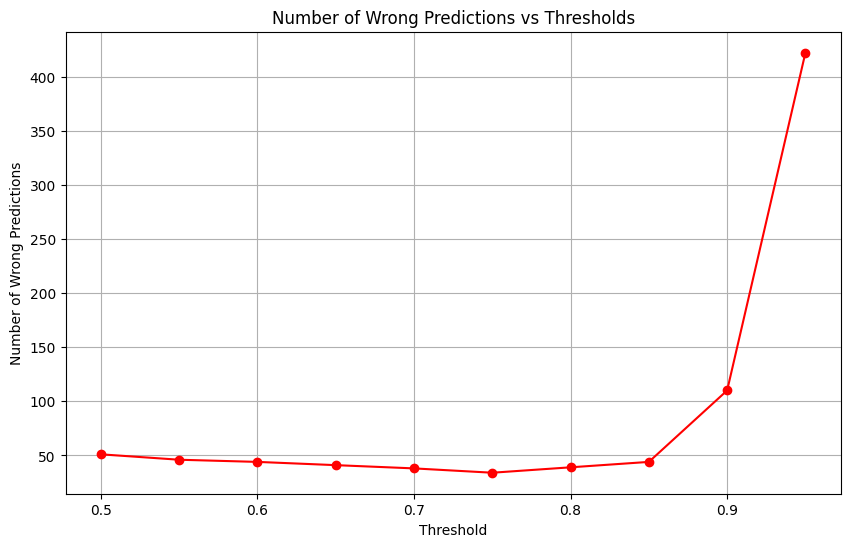

In [42]:
import matplotlib.pyplot as plt
import tensorflow as tf  # Ensure this is imported if using TensorFlow constants

# Define thresholds to test
thresholds = np.arange(0.5, 1.0, 0.05)
wrong_predictions_count = []

y_predicted_by_threshold = {}

# Calculate wrong predictions for each threshold
for threshold in thresholds:
    wrong_predictions = 0
    y_pred_temp = []
    for idx, content in enumerate(padded_sequences):
        interpreter.set_tensor(input_details[0]['index'], [content])
        interpreter.invoke()

        predictions = interpreter.get_tensor(output_details[0]['index'])

        # Apply the threshold
        predicted_label = 1 if predictions[0] > threshold else 0
        y_pred_temp.append(predicted_label)
        
        # Count wrong predictions
        actual_label = df['liberalism_conservative'].iloc[idx]
        if predicted_label != actual_label:
            wrong_predictions += 1

    # Store the count and predictions for this threshold
    wrong_predictions_count.append(wrong_predictions)
    y_predicted_by_threshold[threshold] = y_pred_temp

# Plot the number of wrong predictions vs thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, wrong_predictions_count, marker='o', color='red')
plt.title('Number of Wrong Predictions vs Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Number of Wrong Predictions')
plt.grid(True)
plt.show()